# 2022 EY Data Science Challenge - Level 1 FROG

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from osgeo import gdal

data_path = './'

#### Data Preprocessing

In [3]:
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(data_path+'./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [4]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs(data_path+'/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)
all_frog_data

C:\Users\user\AppData\Local\Temp\ipykernel_34200\1870951489.py:29: DtypeWarning: Columns (2,9,35,39,42,46,47,48,54,56,57,58,59,60,62,64,65,66,68,69,70,71,74,75,76,77,78,79,82,84,85,86,87,88,89,90,92,96,97,99,101,103,109,110,111,114,115,116,117,118,119,120,121,122,123,126,127,128,129,130,135,136,142,143,145,147,148,149,150,151,161,165,170,172,173,174,175,176,177,178,179,180,181,185,189,190,191,192,193,195,207,210,212,215,217,225,226,242,246,254,255) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(data_path+'./training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
935,3108894201,2017-11-12,Australia,Australia,New South Wales,-33.699881,151.043367,Litoria Fallax
941,3108882429,2019-09-19,Australia,Australia,New South Wales,-33.955790,150.976815,Crinia Signifera
944,3108953063,2019-11-03,Australia,Australia,New South Wales,-33.755278,150.623221,Litoria Fallax
945,3108952573,2019-11-04,Australia,Australia,New South Wales,-33.755291,150.623651,Litoria Fallax
980,1452200212,2015-06-16,Australia,Australia,New South Wales,-33.951844,150.870430,Litoria Fallax
...,...,...,...,...,...,...,...,...
193471,3108863070,2018-11-13,Australia,Australia,New South Wales,-33.474900,150.172000,Crinia Signifera
193473,3108900314,2019-10-30,Australia,Australia,New South Wales,-33.789908,151.131394,Litoria Fallax
193476,3108938525,2018-10-17,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193477,3108845537,2019-10-15,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera


In [5]:
df = all_frog_data.iloc[:,[0,1,5,6,7]]
df.head()

,gbifID,eventDate,decimalLatitude,decimalLongitude,species
935,3108894201,2017-11-12,-33.699881,151.043367,Litoria Fallax
941,3108882429,2019-09-19,-33.955790,150.976815,Crinia Signifera
944,3108953063,2019-11-03,-33.755278,150.623221,Litoria Fallax
945,3108952573,2019-11-04,-33.755291,150.623651,Litoria Fallax
980,1452200212,2015-06-16,-33.951844,150.870430,Litoria Fallax


In [6]:
df.shape

(9418, 5)

In [7]:
target_species = 'Litoria Fallax'

df = (
    df
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
df

,gbifID,eventDate,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,3108894201,2017-11-12,-33.699881,151.043367,Litoria Fallax,1,0
1,3108882429,2019-09-19,-33.955790,150.976815,Crinia Signifera,0,1
2,3108953063,2019-11-03,-33.755278,150.623221,Litoria Fallax,1,2
3,3108952573,2019-11-04,-33.755291,150.623651,Litoria Fallax,1,3
4,1452200212,2015-06-16,-33.951844,150.870430,Litoria Fallax,1,4
...,...,...,...,...,...,...,...
9413,3108863070,2018-11-13,-33.474900,150.172000,Crinia Signifera,0,9413
9414,3108900314,2019-10-30,-33.789908,151.131394,Litoria Fallax,1,9414
9415,3108938525,2018-10-17,-33.757622,150.618240,Litoria Fallax,1,9415
9416,3108845537,2019-10-15,-33.718800,150.385000,Crinia Signifera,0,9416


#### get terraclimate data

In [8]:
import warnings

warnings.filterwarnings("ignore", "invalid value", RuntimeWarning)

In [9]:
import pystac

url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
collection

<Collection id=terraclimate>

In [10]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://cpdataeuwest.blob.core.windows.net/cpdata/raw/terraclimate/4000m/raster.zarr>

In [11]:
import fsspec
import xarray as xr
import requests

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [12]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

In [13]:
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

In [14]:
weather_data.band.values

array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean'], dtype='<U9')

#### data joining

In [15]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(df.decimalLongitude, dims="key", coords={"key": df.key}), 
                y=xr.DataArray(df.decimalLatitude, dims="key", coords={"key": df.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(df, weather_data)
model_data.head(10)

,gbifID,eventDate,decimalLatitude,decimalLongitude,species,occurrenceStatus,key,ppt_mean,soil_mean,tmax_mean,tmin_mean
0,3108894201,2017-11-12,-33.699881,151.043367,Litoria Fallax,1,0,85.166664,61.250000,23.146669,12.186667
1,3108882429,2019-09-19,-33.955790,150.976815,Crinia Signifera,0,1,66.983330,53.316666,23.998333,12.873335
2,3108953063,2019-11-03,-33.755278,150.623221,Litoria Fallax,1,2,67.966667,37.950001,23.875002,10.618335
3,3108952573,2019-11-04,-33.755291,150.623651,Litoria Fallax,1,3,67.966667,37.950001,23.875002,10.618335
4,1452200212,2015-06-16,-33.951844,150.870430,Litoria Fallax,1,4,63.099998,46.366665,24.253334,12.241668
5,3108846917,2019-01-14,-33.698834,150.365609,Crinia Signifera,0,5,93.333336,69.133331,19.001669,8.096667
6,1452535942,2015-12-12,-33.837991,151.074188,Litoria Fallax,1,6,73.933334,56.266666,23.933336,13.291668
7,1916646699,2017-10-13,-34.200613,150.705572,Litoria Fallax,1,7,71.483330,60.066666,23.458332,10.941668
8,3108881451,2019-10-23,-33.769160,150.481731,Crinia Signifera,0,8,80.733330,46.916668,21.630001,9.113334
9,3108860938,2019-04-05,-34.038200,150.770000,Crinia Signifera,0,9,66.000000,50.533333,24.066669,11.606668


#### KNN

In [16]:
x = model_data.iloc[:,[7,8,9,10]].values
y = model_data.occurrenceStatus.astype(int)
#y = model_data.iloc[:, 5].values
print(x)
print(y)

[[85.166664 61.25     23.14667  12.186667]
 [66.98333  53.316666 23.998333 12.873335]
 [67.96667  37.95     23.875002 10.618335]
 ...
 [67.96667  37.95     23.875002 10.618335]
 [91.1      62.683334 19.626669  8.335001]
 [84.05     65.48333  23.581669 13.054999]]
0       1
1       0
2       1
3       1
4       1
       ..
9413    0
9414    1
9415    1
9416    0
9417    0
Name: occurrenceStatus, Length: 9418, dtype: int32


In [17]:
type(y)

pandas.core.series.Series

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=50)

In [19]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.fit_transform(x_test)

In [20]:
#set NNeighbors to 5 first for accuracy testing
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=13, metric="minkowski", p=2)
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_pred, y_test)
acc = accuracy_score(y_test, y_pred)
print(cm)
print(acc)

[[1760  344]
 [ 234  488]]
0.7954706298655343


In [22]:
y_pred.mean()

0.25548478414720455

In [23]:
print(f"F1 Score: {np.mean(f1_score(y_test, y_pred)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)).round(2)}")

F1 Score: 0.63
Accuracy: 0.8


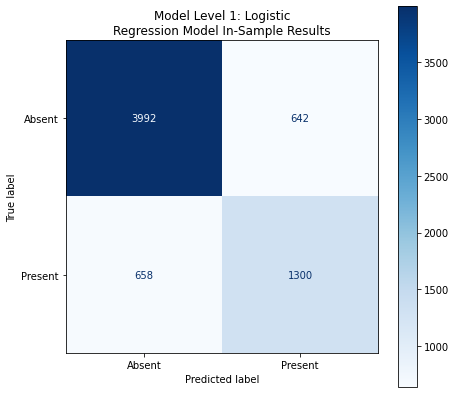

In [24]:
!!!
disp = ConfusionMatrixDisplay.from_estimator(clf, x_train, y_train, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

#### Decision tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
clf_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=8)

In [26]:
clf_entropy = clf_entropy.fit(x_train, y_train)

In [27]:
y_pred = clf_entropy.predict(x_test)

In [28]:
print(f"F1 Score: {np.mean(f1_score(y_test, y_pred)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y_test, y_pred)).round(2)}")

F1 Score: 0.62
Accuracy: 0.78


#### K-fold validation

In [29]:
from sklearn.model_selection import cross_val_score

score = cross_val_score(clf, x, y, scoring='accuracy', cv=4)
score_decision_tree = cross_val_score(clf_entropy, x, y, scoring='accuracy', cv=5)


In [30]:
def display_score(score):
    print("Scores:", score)
    print("Mean", score.mean())
    print('Standard deviation:', score.std())

display_score(score)
display_score(score_decision_tree)

Scores: [0.73375796 0.79617834 0.79991504 0.80628717]
Mean 0.7840346286846078
Standard deviation: 0.02925139352208433
Scores: [0.72929936 0.78397028 0.81953291 0.80403611 0.80775358]
Mean 0.7889184490124513
Standard deviation: 0.0319357826174962


##### Use cross validation to see which nneighbor can provide the highest accuracy 

In [31]:
k_range = range(1,31)
k_scores = []
for k_num in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_num)
    scores = cross_val_score(knn, x, y, scoring='accuracy', cv=10)
    k_scores.append(scores.mean())


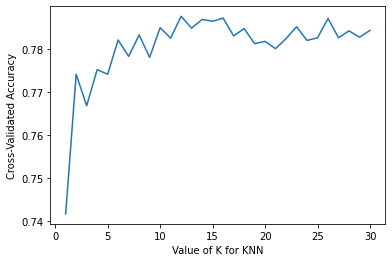

In [32]:
#k=13
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [33]:
k_range = range(2,21)
k_scores = []
for k_num in k_range:
    knn = KNeighborsClassifier(n_neighbors=13)
    scores = cross_val_score(knn, x, y, scoring='accuracy', cv=k_num)
    k_scores.append(scores.mean())


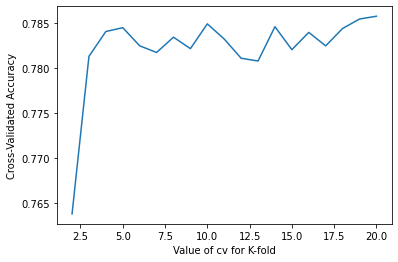

In [34]:
#cv = 4
plt.plot(k_range,k_scores)
plt.xlabel('Value of cv for K-fold')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

### Ready to test real data

In [40]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    print('1:',predictor_image)
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=['ppt_mean', 'soil_mean', 'tmax_mean', 'tmin_mean'])
    print('2:',predictor_image)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    print('3:',null_pixels)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    print('4:',probabilities)
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    print('5:',probabilities[~null_pixels])
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    print('6:',probabilities[null_pixels])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    print('7:',probabilities)
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point 
resultant_image = predict_frogs(weather_data, clf)

1: <xarray.DataArray (z: 262144, band: 4)>
array([[20.555   ,  8.030002, 63.133335, 60.083332],
       [20.555   ,  8.030002, 63.133335, 60.083332],
       [20.555   ,  8.030002, 63.133335, 60.083332],
       ...,
       [23.410004, 11.718335, 74.73333 , 45.283333],
       [23.410004, 11.718335, 74.73333 , 45.283333],
       [23.410004, 11.718335, 74.73333 , 45.283333]], dtype=float32)
Coordinates:
  * band     (band) <U9 'tmax_mean' 'tmin_mean' 'ppt_mean' 'soil_mean'
  * z        (z) MultiIndex
  - y        (z) float64 -34.25 -34.25 -34.25 -34.25 ... -33.25 -33.25 -33.25
  - x        (z) float64 150.2 150.2 150.2 150.2 ... 151.1 151.1 151.1 151.2
2: <xarray.DataArray (z: 262144, band: 4)>
array([[63.133335, 60.083332, 20.555   ,  8.030002],
       [63.133335, 60.083332, 20.555   ,  8.030002],
       [63.133335, 60.083332, 20.555   ,  8.030002],
       ...,
       [74.73333 , 45.283333, 23.410004, 11.718335],
       [74.73333 , 45.283333, 23.410004, 11.718335],
       [74.73333 , 45.28

In [41]:
resultant_image

<xarray.DataArray (y: 512, x: 512)>
array([[0.07692308, 0.07692308, 0.07692308, ...,        nan,        nan,
               nan],
       [0.07692308, 0.07692308, 0.07692308, ...,        nan,        nan,
               nan],
       [0.07692308, 0.07692308, 0.07692308, ...,        nan,        nan,
               nan],
       ...,
       [0.07692308, 0.07692308, 0.07692308, ..., 0.07692308, 0.07692308,
        0.07692308],
       [0.07692308, 0.07692308, 0.07692308, ..., 0.07692308, 0.07692308,
        0.07692308],
       [0.07692308, 0.07692308, 0.07692308, ..., 0.07692308, 0.07692308,
        0.07692308]])
Coordinates:
  * y        (y) float64 -34.25 -34.25 -34.25 -34.24 ... -33.25 -33.25 -33.25
  * x        (x) float64 150.2 150.2 150.2 150.2 ... 151.1 151.1 151.1 151.2

In [54]:
test = pd.read_csv('Level_1_challenge_1_submission_template.csv')

In [55]:
# Read in test regions
test_1_regions = []
with open("D:/Data Science/projects/Frog_SDM_challenge/2022-Better-Working-World-Data-Challenge/notebooks/level_1_challenge/challenge_1_test_regions.txt", 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [56]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

In [57]:
test_regions

[{'title': 0, 'bbox': (144.8, -38.5, 145.8, -37.5)},
 {'title': 1, 'bbox': (150.7, -33.5, 151.7, -32.5)},
 {'title': 2, 'bbox': (152.6, -29.0, 153.6, -28.0)},
 {'title': 3, 'bbox': (145.0, -17.7, 146.0, -16.7)},
 {'title': 4, 'bbox': (115.7, -32.5, 116.7, -31.5)}]

Loading data
Calculating mean
Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


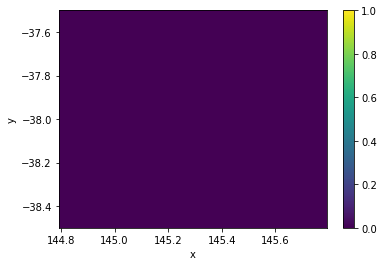

Loading data
Calculating mean
Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


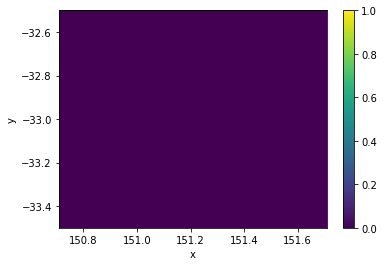

Loading data
Calculating mean
Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


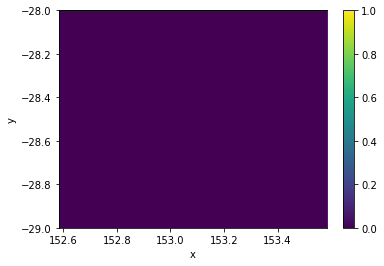

Loading data
Calculating mean
Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


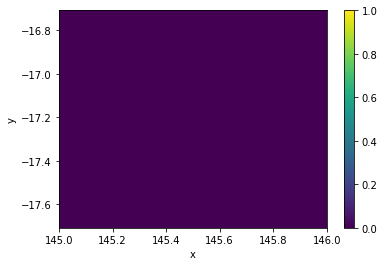

Loading data
Calculating mean
Calculating min
Calculating max


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


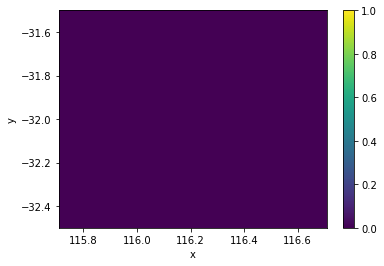

In [58]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], clf) > 0.5
    
    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()
    

In [59]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test.columns]
    .fillna(0)
    .astype({col:'int' for col in test.columns[3::]})
)

C:\Users\user\AppData\Local\Temp\ipykernel_34692\3295402700.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(preds)
C:\Users\user\AppData\Local\Temp\ipykernel_34692\3295402700.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(preds)
C:\Users\user\AppData\Local\Temp\ipykernel_34692\3295402700.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(preds)
C:\Users\user\AppData\Local\Temp\ipykernel_34692\3295402700.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions = predictions.append(preds)
C:\Users\user\AppData\Local\Temp

In [60]:
display(submission)

# Save to output folder
submission.to_csv('Submission_0522.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,0
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,0
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0
